# Ship Route Optimization

When traveling on the surface of the Earth one cannot take a constant heading to travel the shortest route from point **A** to **B**. 

Instead, the heading must be constantly readjusted so that the arc of the trajectory corresponds to the intersection between the globe and a plane that passes through the center of the Earth. 

For ships the ocean currents are an important factor which can be harnessed to produce the optimal path.

## Operation

- This app generates a **Graph** with the (latitude, longitude) grid of ocean points around the globe as vertices.
- Edges are the **8-point** ocean neighbours with weights being the time taken by the ship to travel the length of the edge considering the **Ocean Currents**. 
- This app generates an optimal route for a ship by running **Dijkstra's Shortest Path Algorithm** on this graph with the **Start** and **End** points taken as inputs.


In [6]:
import main

import numpy as np
import helper
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from pyproj import Geod


# WGS84 ellipsoid for geodesic calculations
_geod = Geod(ellps="WGS84")

In [7]:
# Head waters of Bass Straight Port of Hastings, VIC
start_coord = (-38.3, 145.0)  

# Coordinates Wakayama Bay Port of Kobe, Japan
end_coord = (34.0349, 134.5411)  


boat_avg_speed = 1.0

In [ ]:
lon_pre, lat_pre, U_pre, V_pre = main.get_ocean_current_dataset()
lon_post, lat_post, U_post, V_post = main.process_ds(lon_pre, lat_pre, U_pre, V_pre)

# Generate Graph
G = main.graph_factory(lon_post, lat_post, U_post, V_post, boat_avg_speed)

# Get optimal path
path = main.get_optimal_routes(G, start_coord, end_coord, lon_post, lat_post)

# Convert path into list of lat, lon coordinates
xx, yy = main.get_coordinates_from_path_indices(path, lon_post, lat_post)

# densify to N segments for DB / plotting
num_legs = 100
xx_dense, yy_dense, time_total_dist = main.densify_route(xx, yy, num_legs)



100


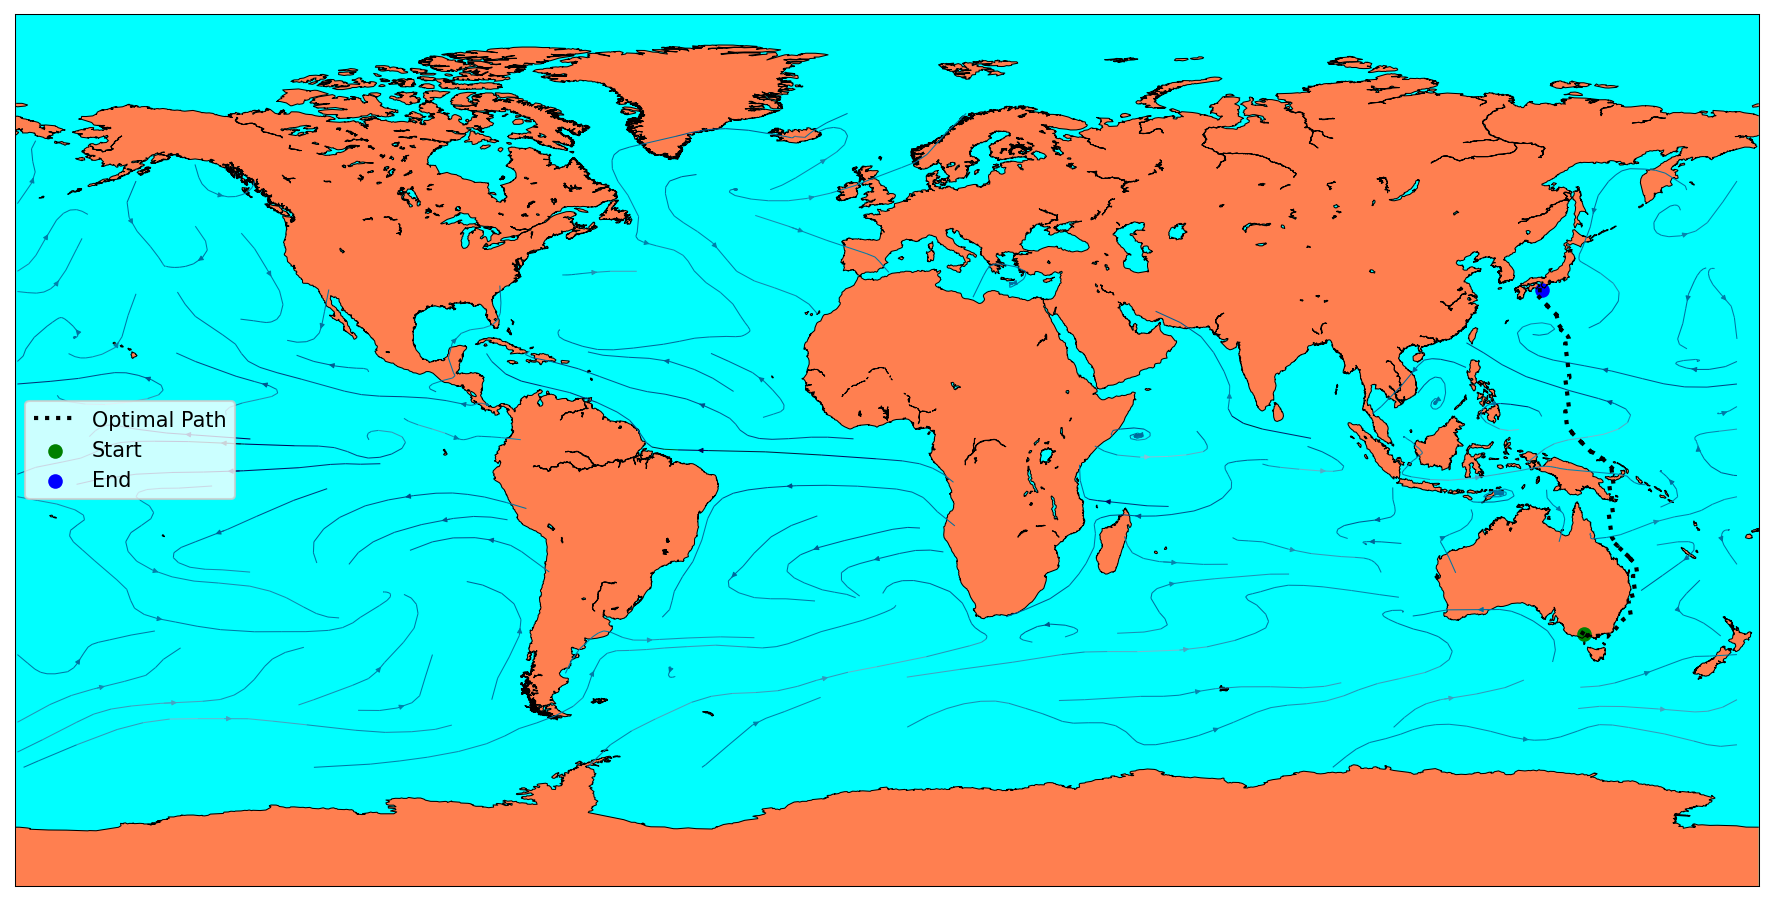

100
100
99
99
[-38.         -37.46208672 -38.52255044 -38.42605919 -38.32956794
 -38.5215167  -37.76745644 -37.21508572 -36.46655443 -35.72474174]
[144.         143.1295854  144.99664846 145.99597653 146.9953064
 148.7686597  149.3658671  150.21892863 150.81217802 151.41112265]


In [ ]:
fig = main.plot_matplot(lon_post, lat_post, U_post, V_post, xx_dense, yy_dense)

plt.rcParams["figure.figsize"] = (12, 6)   # width, height in inches
plt.rcParams["figure.dpi"] = 150          # render resolution
plt.rcParams["savefig.dpi"] = 300

plt.show()

print(len(xx_dense))
print(len(yy_dense))

# assuming xx_dense = lons, yy_dense = lats
total, segment_dists, segment_bearings = main.path_distance_and_bearings(
    xx_dense, yy_dense
)

ROUTE COMPARISON STATISTICS
Distance-Optimal Route (Great Circle): 8080.98 km
Time-Optimal Route (Current-Assisted): 12581.61 km
Difference: 4500.63 km
Time-optimal route is 55.7% longer


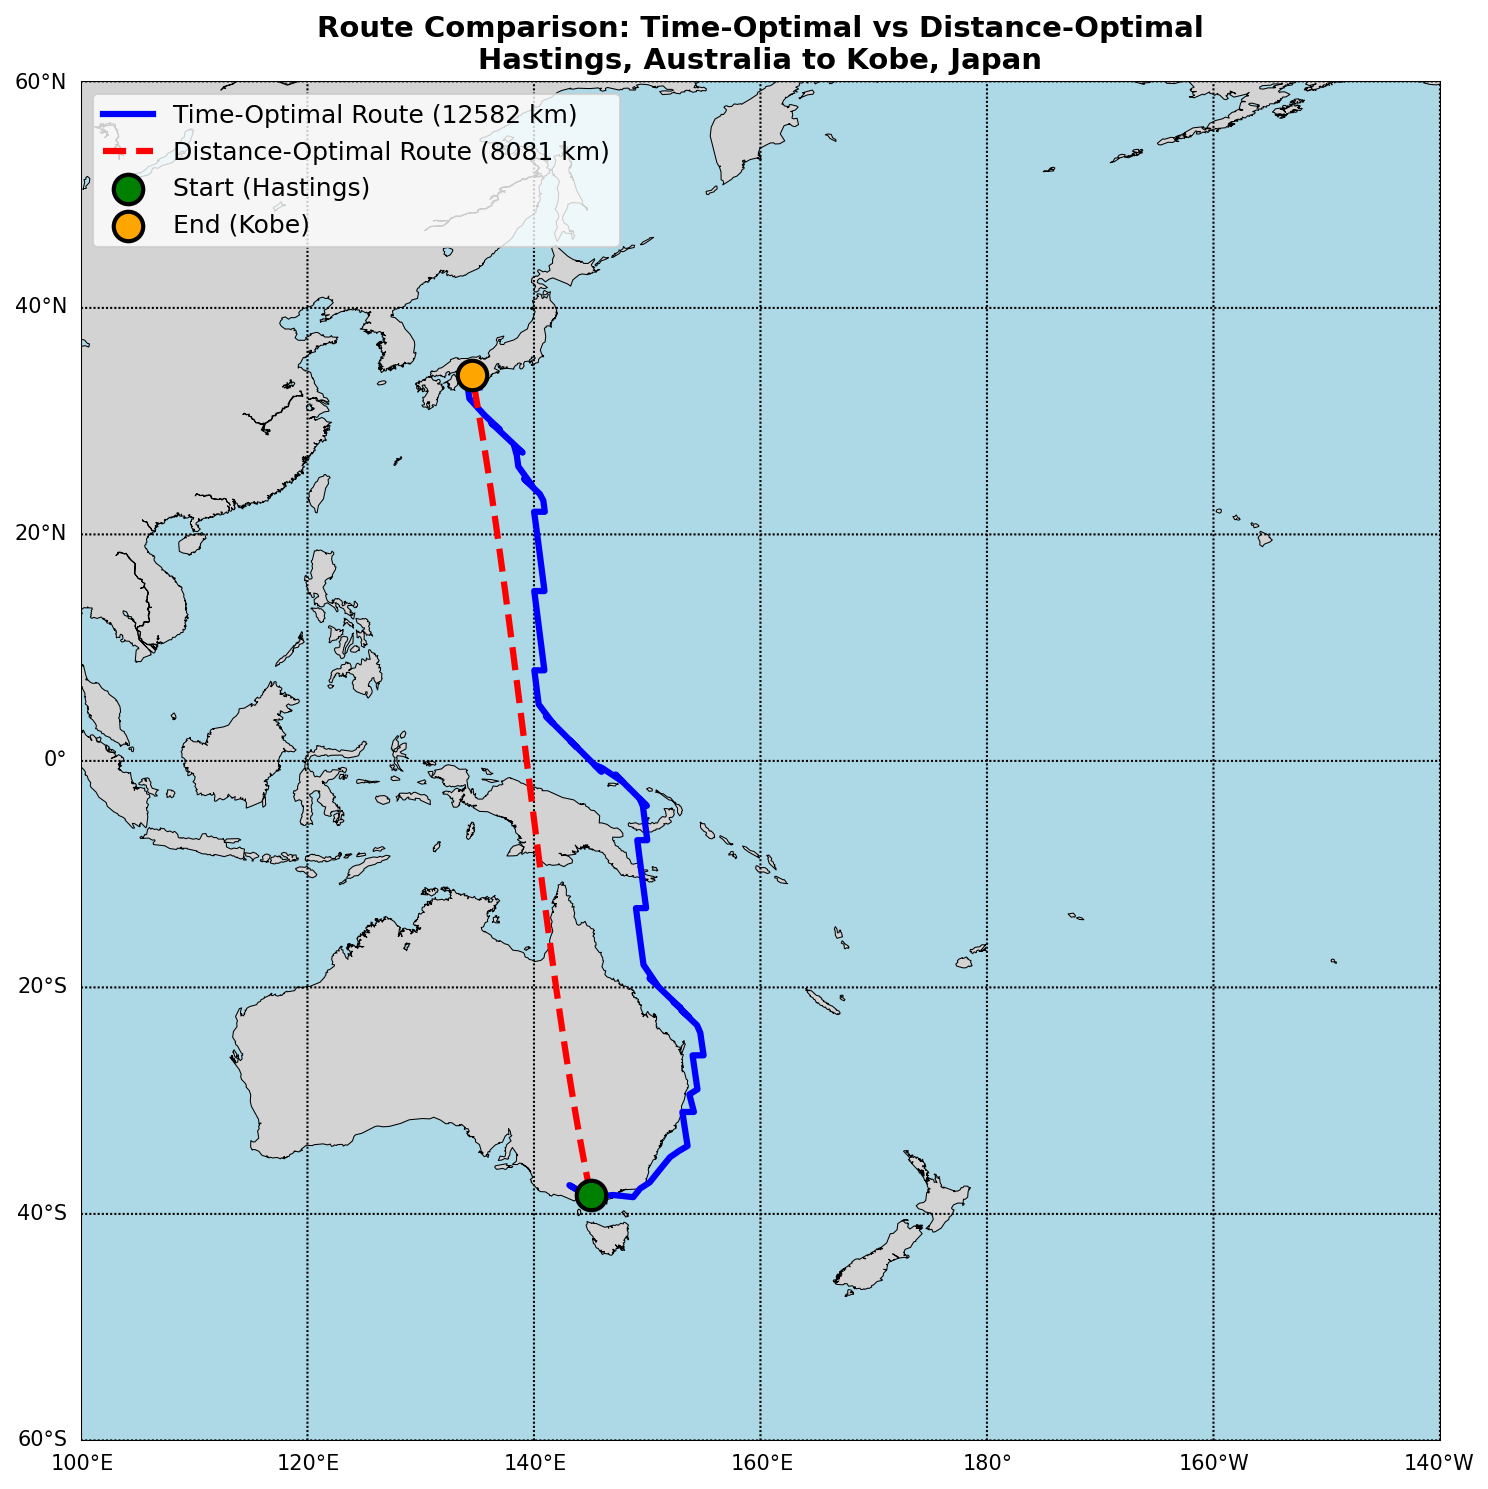

In [23]:
fig = main.plot_comparison(
    lon_post,
    lat_post,
    U_post,
    V_post,
    xx_dense,   # time-optimal lons
    yy_dense,   # time-optimal lats
    start_coord,
    end_coord
)
plt.show()


In [25]:
# assuming xx_dense = lons, yy_dense = lats
total, segment_dists, segment_bearings = main.path_distance_and_bearings(
    xx_dense, yy_dense
)

print(len(segment_dists))
print(len(segment_bearings))

print(total / 1000)          # km
print(segment_dists[:10])    # first few segment distances
print(segment_bearings[:10]) # first few bearings (radians or deg, depending on implementation)


99
99
12581.612810440987
[ 97143.75051903 201671.31119783  87653.28986259  87768.87896289
 155945.18087076  98781.7615862   97143.75051898  98563.24297609
  98487.69268918  98414.00881713]
[ 2.4829611  -0.63447063  0.11728474  0.11713382 -0.14690308  1.01050799
  0.67992737  1.0024385   0.98964016  0.97725691]


In [17]:
import psycopg2
from psycopg2 import sql
from datetime import datetime
import numpy as np
import helper


def store_routes_in_database(time_opt_lons, time_opt_lats,
                             dist_opt_lons, dist_opt_lats,
                             time_total_dist, dist_total_dist,
                             db_name, db_user, db_password,
                             db_host, db_port,
                             route_name):
    """
    Store both time-optimal and distance-optimal routes in PostgreSQL database.
    All routes (lat/lon) and total distances are precomputed.

    Parameters
    ----------
    time_opt_lons, time_opt_lats : array-like
        Longitudes and latitudes of time-optimal route.
    dist_opt_lons, dist_opt_lats : array-like
        Longitudes and latitudes of distance-optimal route.
    time_total_dist, dist_total_dist : float
        Total route distances in meters.
    db_name, db_user, db_password, db_host, db_port
        Database connection parameters.
    route_name : str
        Identifier for this route pair.

    Returns
    -------
    dict
        Summary of inserted records.
    """

    # Connect to database
    conn = psycopg2.connect(
        dbname=db_name,
        user=db_user,
        password=db_password,
        host=db_host,
        port=db_port
    )
    cur = conn.cursor()

    # Function to insert route points
    def insert_route(lons, lats, route_type):
        cumulative_dist = 0.0
        records_inserted = 0

        for i in range(len(lons)):
            if i == 0:
                dist_from_prev = 0.0
            else:
                dist_from_prev = helper.distance(
                    lats[i-1], lons[i-1],
                    lats[i],   lons[i]
                )
                cumulative_dist += dist_from_prev

            insert_query = """
            INSERT INTO voyage_routes 
                (route_name, route_type, point_sequence, latitude, longitude, 
                 distance_from_start, cumulative_distance)
            VALUES (%s, %s, %s, %s, %s, %s, %s)
            ON CONFLICT (route_name, route_type, point_sequence) 
            DO UPDATE SET 
                latitude = EXCLUDED.latitude,
                longitude = EXCLUDED.longitude,
                distance_from_start = EXCLUDED.distance_from_start,
                cumulative_distance = EXCLUDED.cumulative_distance,
                created_at = CURRENT_TIMESTAMP;
            """

            cur.execute(insert_query, (
                route_name,
                route_type,
                i,
                float(lats[i]),
                float(lons[i]),
                float(dist_from_prev),
                float(cumulative_dist)
            ))
            records_inserted += 1

        return records_inserted, cumulative_dist

    # Insert time-optimal route
    print("Inserting time-optimal route points...")
    time_records, _ = insert_route(time_opt_lons, time_opt_lats, 'time_optimal')

    # Insert distance-optimal route
    print("Inserting distance-optimal route points...")
    dist_records, _ = insert_route(dist_opt_lons, dist_opt_lats, 'distance_optimal')

    # Commit and close
    conn.commit()
    cur.close()
    conn.close()

    # Summary
    summary = {
        'route_name': route_name,
        'time_optimal': {
            'points': time_records,
            'total_distance_km': time_total_dist / 1000.0
        },
        'distance_optimal': {
            'points': dist_records,
            'total_distance_km': dist_total_dist / 1000.0
        }
    }

    print("\n" + "=" * 60)
    print("DATABASE STORAGE COMPLETE")
    print("=" * 60)
    print(f"Route Name: {route_name}")
    print(f"\nTime-Optimal Route:")
    print(f"  - Points inserted: {time_records}")
    print(f"  - Total distance: {time_total_dist/1000:.2f} km")
    print(f"\nDistance-Optimal Route:")
    print(f"  - Points inserted: {dist_records}")
    print(f"  - Total distance: {dist_total_dist/1000:.2f} km")
    print("=" * 60)

    return summary


In [18]:
import psycopg2
import pandas as pd


def query_route_from_database(db_name, db_user, db_password,
                              route_name, route_type,
                              db_host='localhost', db_port=5432):
    """
    Query route points from PostgreSQL into a pandas DataFrame.

    Parameters
    ----------
    db_name, db_user, db_password, db_host, db_port
        Database connection parameters.
    route_name : str
        Name identifier for the route (e.g. 'Hastings_to_Kobe_2026').
    route_type : str
        Either 'time_optimal' or 'distance_optimal'.

    Returns
    -------
    pandas.DataFrame
        Columns: point_sequence, latitude, longitude,
                 distance_from_start, cumulative_distance, created_at.
    """

    conn = psycopg2.connect(
        dbname=db_name,
        user=db_user,
        password=db_password,
        host=db_host,
        port=db_port
    )

    query = """
        SELECT point_sequence,
               latitude,
               longitude,
               distance_from_start,
               cumulative_distance,
               created_at
        FROM voyage_routes
        WHERE route_name = %s
          AND route_type = %s
        ORDER BY point_sequence;
    """

    df = pd.read_sql_query(query, conn, params=(route_name, route_type))
    conn.close()
    return df


In [19]:
# Store both routes in database
summary = store_routes_in_database(
    time_opt_lons=xx,
    time_opt_lats=yy,
    start_coord=start_coord,
    end_coord=end_coord,
    db_name='postgres',
    db_user='postgres',
    db_password='Test1234',          # or 'Test1234' if that is the actual password
    db_host='localhost',
    db_port=5432,
    route_name='Hastings_to_Kobe_2026'
)

# Query back the data
time_optimal_df = query_route_from_database(
    db_name='postgres',
    db_user='postgres',
    db_password='Test1234',          # or 'Test1234'
    route_name='Hastings_to_Kobe_2026',
    route_type='time_optimal'
)

print(time_optimal_df.head())


TypeError: store_routes_in_database() got an unexpected keyword argument 'start_coord'